In [1]:
import massp
import polars as pl
import pylab as plt
import numpy as np
%matplotlib widget

In [2]:
noise_path = r"C:\Users\oneilg\Desktop\python\src\mass\tests\ljh_files\20230626\0000\20230626_run0000_chan4102.ljh";
pulse_path = r"C:\Users\oneilg\Desktop\python\src\mass\tests\ljh_files\20230626\0001\20230626_run0001_chan4102.ljh";

ljh_noise = massp.LJHFile(noise_path)
df_noise, header_df_noise = ljh_noise.to_polars()
ljh = massp.LJHFile(pulse_path)
df, header_df = ljh.to_polars()

In [3]:
df

pulse,posix_usec,rowcount
"array[u16, 1000]",u64,u64
"[7865, 7868, … 7906]",1687806443167310,5362435359
"[7863, 7863, … 7913]",1687806443218158,5362844889
"[7861, 7864, … 7935]",1687806443247417,5363080509
"[7858, 7857, … 7888]",1687806443979909,5368982163
"[7858, 7862, … 7893]",1687806444017011,5369281077
…,…,…
"[7842, 7841, … 7911]",1687807707682780,15550181829
"[7853, 7846, … 7919]",1687807707768353,15550865655
"[7848, 7848, … 7892]",1687807708118172,15553689564


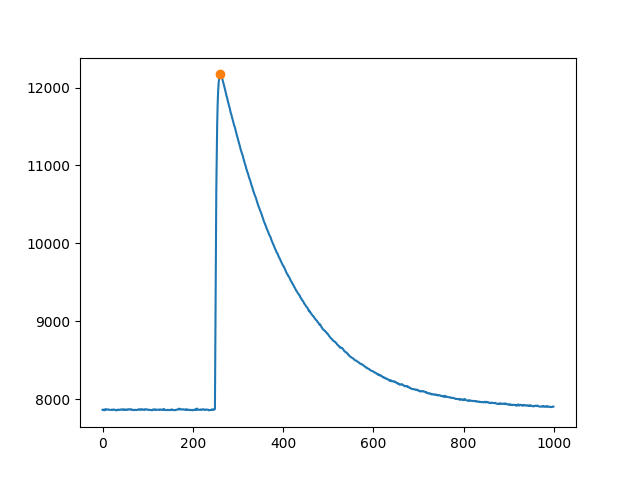

In [4]:
peak_ind = np.argmax(df["pulse"][0])
plt.plot(df["pulse"][0])
plt.plot(peak_ind,df["pulse"][0].to_numpy()[peak_ind],"o")

In [5]:
header_df

Save File Format Version,Software Version,Software Git Hash,Data source,Number of rows,Number of columns,Row number (from 0-32 inclusive),Column number (from 0-0 inclusive),Number of channels,Channel name,Channel,ChannelIndex (in dastard),Digitized Word Size In Bytes,Presamples,Total Samples,Number of samples per point,Timestamp offset (s),Server Start Time,First Record Time,Pixel X Position,Pixel Y Position,Pixel Name,Timebase,Number of Columns
str,str,str,str,i64,str,str,str,str,str,i64,str,str,i64,i64,str,str,str,str,str,str,str,f64,i64
"""2.2.1""","""DASTARD version 0.2.11""","""a573d0d""","""Abaco""",33,"""1""","""6""","""0""","""33""","""chan4102""",4102,"""6""","""2""",250,1000,"""1""","""1687805769.518140""","""26 Jun 2023, 12:56:09 MDT""","""26 Jun 2023, 13:07:23 MDT""","""0""","""0""","""""",0.000004,1


In [6]:
df2=df.with_columns(df.select(pl.from_epoch(pl.col("posix_usec"), time_unit="us").alias("timestamp")))

In [7]:
df3=pl.concat(pl.from_numpy(massp.pulse_algorithms.summarize_data_numba(df_iter["pulse"].to_numpy(), header_df["Timebase"][0], peak_samplenumber=peak_ind, pretrigger_ignore=0, 
                                                      nPresamples=header_df["Presamples"][0])) for df_iter in df.iter_slices()).with_columns(df2)
df3

pretrig_mean,pretrig_rms,pulse_average,pulse_rms,promptness,rise_times,postpeak_deriv,peak_index,peak_value,min_value,shift1,pulse,posix_usec,rowcount,timestamp
f32,f32,f32,f32,f32,f32,f32,u16,u16,u16,u16,"array[u16, 1000]",u64,u64,datetime[μs]
7865.76416,3.830966,964.138794,1502.27002,0.850082,0.000026,2.5,261,4303,7857,0,"[7865, 7868, … 7906]",1687806443167310,5362435359,2023-06-26 19:07:23.167310
7864.116211,3.750006,1180.810791,1818.188477,0.805784,0.000034,1.6,261,5092,7853,0,"[7863, 7863, … 7913]",1687806443218158,5362844889,2023-06-26 19:07:23.218158
7864.571777,3.553705,1597.097778,2399.770752,0.800266,0.000034,1.1,262,6363,7854,0,"[7861, 7864, … 7935]",1687806443247417,5363080509,2023-06-26 19:07:23.247417
7861.244141,4.265263,576.881165,917.346619,0.846833,0.000024,2.6,261,2735,7849,0,"[7858, 7857, … 7888]",1687806443979909,5368982163,2023-06-26 19:07:23.979909
7860.724121,7.838866,936.859192,1460.672485,0.785008,0.000028,1.2,261,4195,7850,1,"[7858, 7862, … 7893]",1687806444017011,5369281077,2023-06-26 19:07:24.017011
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
7843.536133,4.044837,1598.19104,2402.710938,0.808249,0.000027,0.5,262,6380,7833,0,"[7842, 7841, … 7911]",1687807707682780,15550181829,2023-06-26 19:28:27.682780
7844.476074,4.241866,1580.461426,2375.43457,0.780327,0.000032,1.4,263,6329,7832,0,"[7853, 7846, … 7919]",1687807707768353,15550865655,2023-06-26 19:28:27.768353
7846.855957,3.658861,1182.518188,1822.665283,0.810456,0.000027,2.2,262,5108,7837,0,"[7848, 7848, … 7892]",1687807708118172,15553689564,2023-06-26 19:28:28.118172


In [8]:
df_noise

pulse,posix_usec,rowcount
"array[u16, 1000]",u64,u64
"[7882, 7879, … 7875]",1687806373126882,4798144731
"[7879, 7876, … 7880]",1687806373130978,4798177731
"[7877, 7883, … 7881]",1687806373135074,4798210731
"[7882, 7883, … 7884]",1687806373139170,4798243731
"[7882, 7884, … 7884]",1687806373143266,4798276731
…,…,…
"[7884, 7884, … 7879]",1687806375604968,4818109731
"[7886, 7884, … 7888]",1687806375609064,4818142731
"[7883, 7884, … 7888]",1687806375613160,4818175731


In [9]:
df_noise["pulse"].to_numpy().shape

(610, 1000)

In [10]:
def excursion(noise_trace):
    return np.amax(noise_trace)-np.amin(noise_trace)
df_noise2 = df_noise.with_columns(df_noise["pulse"].map_elements(excursion, return_dtype=pl.Int64).alias("excursion"))
df_noise2

pulse,posix_usec,rowcount,excursion
"array[u16, 1000]",u64,u64,i64
"[7882, 7879, … 7875]",1687806373126882,4798144731,29
"[7879, 7876, … 7880]",1687806373130978,4798177731,24
"[7877, 7883, … 7881]",1687806373135074,4798210731,25
"[7882, 7883, … 7884]",1687806373139170,4798243731,26
"[7882, 7884, … 7884]",1687806373143266,4798276731,26
…,…,…,…
"[7884, 7884, … 7879]",1687806375604968,4818109731,28
"[7886, 7884, … 7888]",1687806375609064,4818142731,27
"[7883, 7884, … 7888]",1687806375613160,4818175731,28


In [11]:
def median_absolute_deviation(x):
    return np.median(np.abs(x-np.median(x)))
def sigma_mad(x):
    return median_absolute_deviation(x)*1.4826
def outlier_resistant_nsigma_above_mid(x, nsigma=5):
    mid = np.median(x)
    mad = np.median(np.abs(x-mid))
    sigma_mad = mad*1.4826
    return mid+nsigma*sigma_mad

In [12]:
max_excursion = outlier_resistant_nsigma_above_mid(df_noise2["excursion"], nsigma=5); max_excursion

34.413

In [13]:
#warning do not use select("pulse") as that returns a DF, we want to call to_numpy on a series
noise_data=df_noise2.filter(pl.col("excursion") < max_excursion).limit(10000)["pulse"].to_numpy()

In [14]:
noise_data.shape

(610, 1000)

In [15]:
spectrum = massp.noise_psd(noise_data, dt=header_df["Timebase"][0])

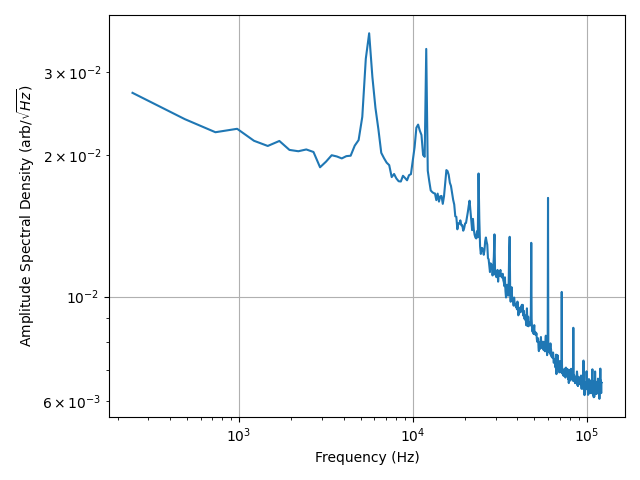

In [16]:
spectrum.plot()

In [17]:
# choose max pretrigger_rms and post_peak_deriv to find clean pulses for average pulse
max_postpeak_deriv = outlier_resistant_nsigma_above_mid(df3["postpeak_deriv"].to_numpy(), nsigma=20)
max_pretrig_rms = outlier_resistant_nsigma_above_mid(df3["pretrig_rms"].to_numpy(),nsigma=20)
good_expr = (pl.col("postpeak_deriv")<max_postpeak_deriv).and_(pl.col("pretrig_rms")<max_pretrig_rms)
df_good = df3.lazy().filter(good_expr)
df_bad = df3.lazy().filter(good_expr.not_())
df_bad_pretrig = df3.lazy().filter(pl.col("pretrig_rms")>max_pretrig_rms)
avg_pulse = df_good.select("pulse").limit(1000).collect()["pulse"].to_numpy().mean(axis=0)

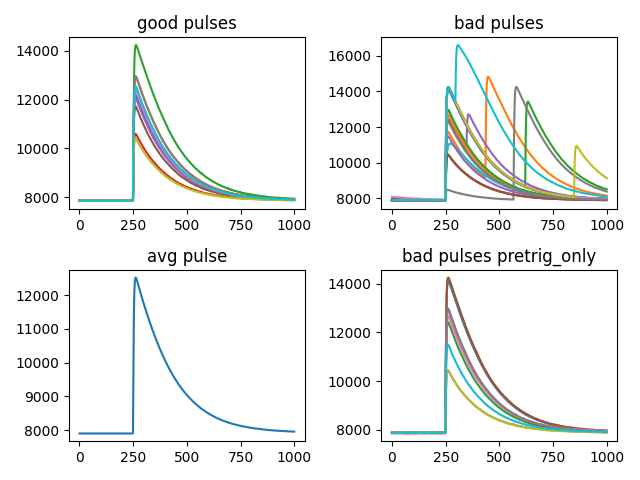

In [18]:
fig, axes = plt.subplots(2,2)
plt.sca(axes[0,0])
plt.plot(df_good.select("pulse").limit(10).collect()["pulse"].to_numpy().T);
plt.title("good pulses")
plt.sca(axes[0,1])
plt.plot(df_bad.select("pulse").limit(20).collect()["pulse"].to_numpy().T);
plt.title("bad pulses")
plt.sca(axes[1,0])
plt.plot(avg_pulse)
plt.title("avg pulse")
plt.sca(axes[1,1])
plt.plot(df_bad_pretrig.select("pulse").limit(10).collect()["pulse"].to_numpy().T);
plt.title("bad pulses pretrig_only")
plt.tight_layout()

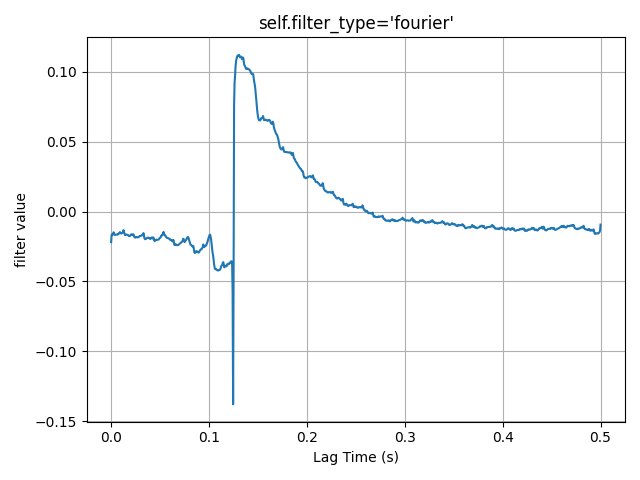

In [19]:
filter = massp.fourier_filter(avg_signal=avg_pulse, noise_psd=spectrum.psd, dt=1)
filter.plot()

In [20]:
avg_pulse_size = np.amax(avg_pulse)-avg_pulse[0]
def apply_filter(pulse):
    return np.dot(filter.filter, pulse)*avg_pulse_size*2e-5
filt_value = df3["pulse"].map_elements(apply_filter, return_dtype=pl.Float64).rename("filt_value")
df4 = df3.with_columns(filt_value);
filt_value

filt_value
f64
3549.665589
4172.941482
5280.571989
2360.515228
3463.950271
…
5288.155062
5228.733565
4183.43436


In [21]:
def midpoints_and_step_size(x):
    d = np.diff(x)
    step_size=d[0]
    assert all(d==step_size)
    return x[:-1]+step_size, step_size
bin_edges = np.arange(0,10000,10)
hist = df4["filt_value"].rename("count").hist(np.arange(0,10000,10), include_category=False, include_breakpoint=False)[1:-1]
hist

count
u32
0
0
1
0
0
…
0
0
0


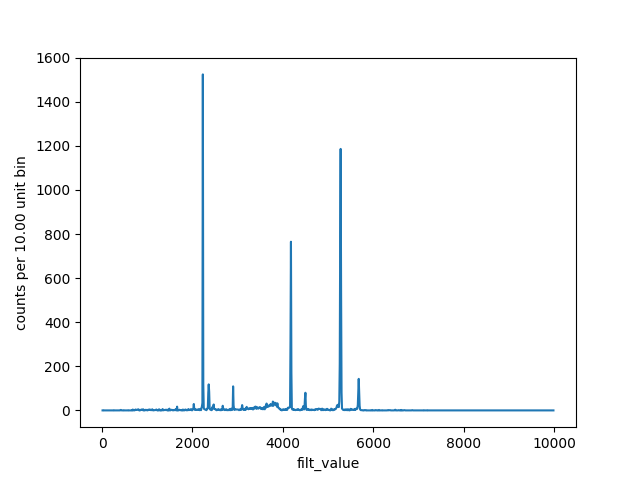

In [22]:
def plot_hist(series, bin_edges, axis=None, **plotkwarg):
    if axis is None:
        plt.figure()
        axis = plt.gca()
    bin_centers, step_size = midpoints_and_step_size(bin_edges)
    hist = series.rename("count").hist(bin_edges, include_category=False, include_breakpoint=False)[1:-1]
    axis.plot(bin_centers, hist, label=series.name, **plotkwarg)
    axis.set_xlabel(series.name)
    axis.set_ylabel(f"counts per {step_size:.2f} unit bin")
plot_hist(df4["filt_value"], np.arange(0,10000,10))


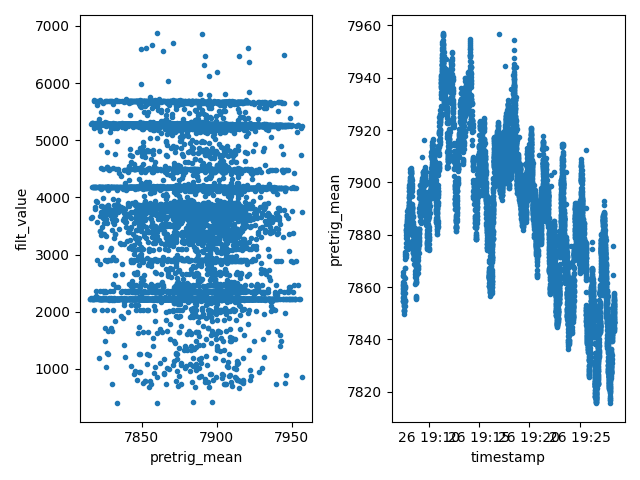

In [23]:
def plot_a_vs_b_series(a, b, axis=None, **plotkwarg):
    if axis is None:
        plt.figure()
        axis = plt.gca()
    axis.plot(a, b, ".", label=b.name, **plotkwarg)
    axis.set_xlabel(a.name)
    axis.set_ylabel(b.name)
fig, axes = plt.subplots(1,2)
plot_a_vs_b_series(df4.filter(good_expr)["pretrig_mean"], df4.filter(good_expr)["filt_value"], axes[0])
plot_a_vs_b_series(df4.filter(good_expr)["timestamp"], df4.filter(good_expr)["pretrig_mean"], axes[1])
plt.tight_layout()

In [24]:
df_dc=df4.filter(good_expr).select("pretrig_mean", "filt_value")
dc=massp.drift_correct(indicator=df_dc["pretrig_mean"].to_numpy(), uncorrected=df_dc["filt_value"].to_numpy())
dc

DriftCorrection(offset=7887.976, slope=4.161938117342884e-05)

In [25]:
m, b = dc.slope, dc.offset
df5=df4.select((pl.col("filt_value")*(1+m*(pl.col("pretrig_mean")-b))).alias("filt_value_dc")).with_columns(df4)
# df5 = df4.select("filt_value", gain=(1+m*(pl.col("pretrig_mean")-b))).select("gain",filt_value_dc=pl.col("filt_value")*pl.col("gain"))
# df5
# df4.select(pl.col("pretrig_mean")-b)

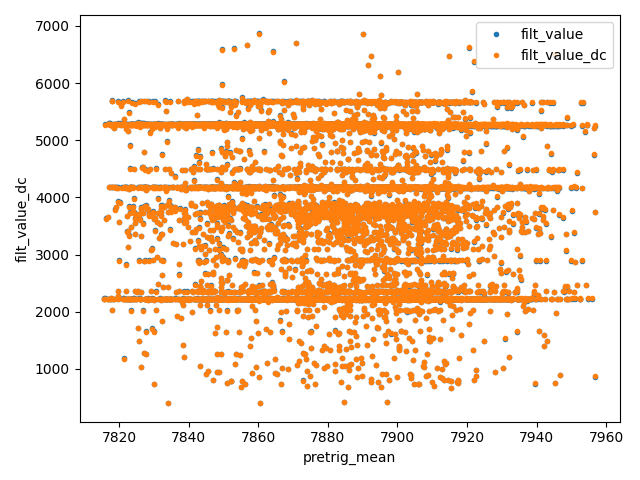

In [26]:
plot_a_vs_b_series(df5.filter(good_expr)["pretrig_mean"], df5.filter(good_expr)["filt_value"])
plot_a_vs_b_series(df5.filter(good_expr)["pretrig_mean"], df5.filter(good_expr)["filt_value_dc"], plt.gca())
plt.legend()
plt.tight_layout()

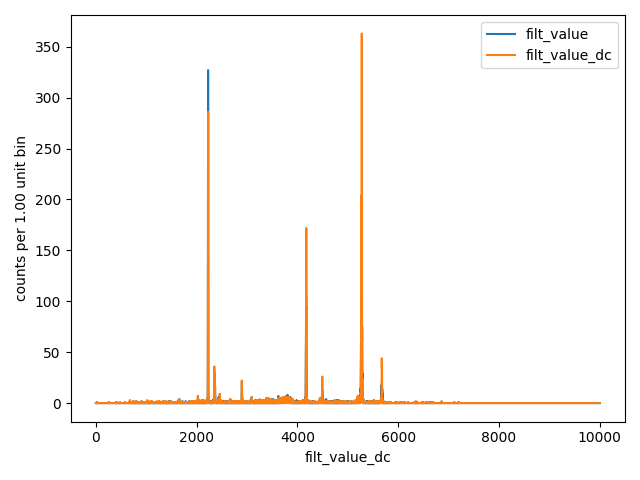

In [27]:
plot_hist(df5["filt_value"], np.arange(0,10000,1))
plot_hist(df5["filt_value_dc"], np.arange(0,10000,1), axis=plt.gca())
plt.legend()
plt.tight_layout()

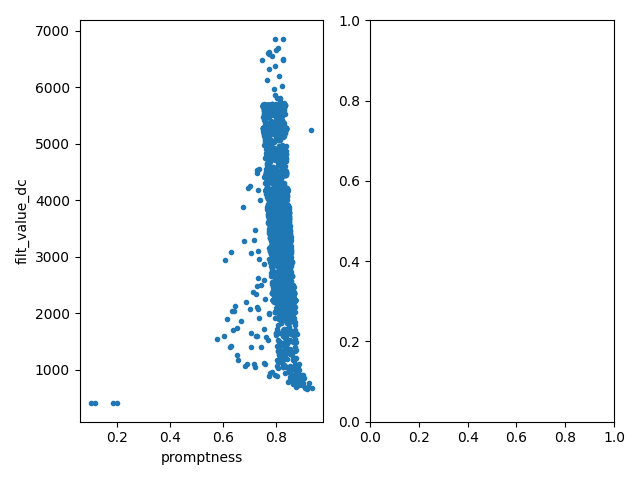

In [28]:
fig, axes = plt.subplots(1,2)
plot_a_vs_b_series(df5.filter(good_expr)["promptness"], df5.filter(good_expr)["filt_value_dc"], axes[0])
plt.tight_layout()

In [42]:
ch = pl.Series("ch", dtype=pl.Int64).extend_constant(header_df["Channel"], len(df5))
df_export = df5.select("filt_value_dc","timestamp").with_columns(ch).select("ch","timestamp","filt_value_dc") # re-order
df_export


ch,timestamp,filt_value_dc
i64,datetime[μs],f64
4102,2023-06-26 19:07:23.167310,3546.384115
4102,2023-06-26 19:07:23.218158,4168.797615
4102,2023-06-26 19:07:23.247417,5275.42833
4102,2023-06-26 19:07:23.979909,2357.888998
4102,2023-06-26 19:07:24.017011,3460.021427
…,…,…
4102,2023-06-26 19:28:27.682780,5278.374287
4102,2023-06-26 19:28:27.768353,5219.267241
4102,2023-06-26 19:28:28.118172,4176.274857


In [43]:
df_export.write_parquet("out.parquet")